In [2]:
import pytesseract
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
def load_yolo():
    path_to_cfg = "/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.cfg" 
    path_to_weights = "/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.weights"
    net = cv2.dnn.readNet(path_to_weights, path_to_cfg)
    layers_names = net.getLayerNames()
    
    # Handling different versions of OpenCV which may return different formats
    try:
        output_layers = [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    except Exception:
        output_layers = [layers_names[i - 1] for i in net.getUnconnectedOutLayers()]

    return net, output_layers


def yolo_detect(net, image, output_layers, confidence_threshold=0.3):  # Lowered threshold
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    boxes = []
    confidences = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold and class_id == 0:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                if x >= 0 and y >= 0 and (x + w) <= width and (y + h) <= height:
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))

    # Select the largest vertical box based on area if any boxes were detected
    if boxes:
        largest_box = max(boxes, key=lambda b: b[2] * b[3])  # b[2]*b[3] is the area of the box (w*h)
        largest_confidence = confidences[boxes.index(largest_box)]
        return [largest_box], [largest_confidence]
    return [], []  # Return empty lists if no boxes detected


In [4]:
# Specify the path to tesseract executable
pytesseract.pytesseract.tesseract_cmd = ('/opt/homebrew/bin/tesseract')  # Update this path according to your system

# Example player database with both full reference name and jersey name
player_database = {
    "Virat_Kohli": {"name": "VIRAT", "number": "18"},
    "Arshdeep_Singh": {"name": "ARSHDEEP", "number": "2"},
    "Axar_Patel": {"name": "AXAR", "number": "20"},
    "Jasprit_Bumrah": {"name": "JASPRIT", "number": "93"},
    "Kuldeep_Yadav": {"name": "KULDEEP", "number": "23"},
    "Ravindra_Jadeja": {"name": "JADEJA", "number": "8"}
}

In [5]:
def process_frame_for_OCR_text_detection(image):

    # Convert image to RGB for consistent display if originally in BGR
    if image.shape[2] == 3:  # assuming the image has 3 channels
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Original dimensions
    (H, W) = image.shape[:2]

    # Set the new width and height to nearest multiple of 32 for EAST model
    newW = int(W / 32) * 32
    newH = int(H / 32) * 32

    # Resize the image to fit model requirements
    image = cv2.resize(image, (newW, newH))

    # Load the pre-trained EAST text detector model
    model_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/frozen_east_text_detection.pb'
    net = cv2.dnn.readNet(model_path)

    # Prepare the image for the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)

    # Layer names for the output layers
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Forward pass of the model to get output
    (scores, geometry) = net.forward(layerNames)

    # Decode the predictions
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # Loop over the number of rows
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # Loop over the number of columns
        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression to avoid overlaps
    indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

    # Plot the figures side by side
    plt.figure(figsize=(18, 12))


    # # Plot original detections
    # plt.subplot(1, 3, 1)
    # plt.imshow(image)
    # for i in indices.flatten():
    #     (startX, startY, endX, endY) = rects[i]
    #     rect = plt.Rectangle((startX, startY), endX - startX, endY - startY, edgecolor='r', facecolor='none')
    #     plt.gca().add_patch(rect)
    # plt.title('Original Detections')
    # plt.axis('off')


    # Plot original detections
    plt.subplot(1, 3, 1)
    plt.imshow(image)

    if len(indices) > 0:
        indices = indices.flatten()  # Ensuring flattening is possible

        # # Plotting and processing detections
        # plt.figure(figsize=(10, 6))

        for i in indices.flatten():
            (startX, startY, endX, endY) = rects[i]
            rect = plt.Rectangle((startX, startY), endX - startX, endY - startY, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
    plt.title('Original Detections')
    plt.axis('off')

    # Plot merged box
    plt.subplot(1, 3, 2)
    plt.imshow(image)

    cropped_img = None

    if len(indices) > 0:
        min_x = max(0, min([rects[i][0] for i in indices]) - 20)
        min_y = max(0, min([rects[i][1] for i in indices]) - 20)
        max_x = min(W, max([rects[i][2] for i in indices]) + 20)
        max_y = min(H, max([rects[i][3] for i in indices]) + 20)

        cropped_img = image[min_y:max_y, min_x:max_x]

        merged_rect = plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, edgecolor='r', facecolor='none')
        plt.gca().add_patch(merged_rect)
        plt.title('Merged Detections with Expanded Box')
    else:
        plt.title('No Detections Found')
    plt.axis('off')

    # Display the cropped area from the merged box
    plt.subplot(1, 3, 3)
    if len(indices) > 0:
        plt.imshow(cropped_img)
        plt.title('Cropped Area from Merged Box')
    else:
        plt.title('No Area to Crop')
    plt.axis('off')

    plt.show()


    # Proceed with text recognition on the cropped image
    if cropped_img is not None:
        # Convert cropped image from RGB to BGR for OpenCV operations
        cropped_img_bgr = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR)
        
        # Convert to grayscale
        gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)

        # # Apply thresholding
        # _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

        # Use median blur to remove noise
        blur = cv2.medianBlur(gray, 5)

        # # Resize for better accuracy
        # resized_img = cv2.resize(blur, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

        # Configure parameters for Tesseract
        custom_config = r'--oem 3 --psm 11'
        text = pytesseract.image_to_string(blur, config=custom_config)

        # plotting the preprocessing visualization of the cropped image
        plt.figure(figsize=(12, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
        plt.title('Grayscale')

        plt.subplot(1, 3, 2)
        plt.imshow(blur, cmap='gray')
        plt.title('Median Blur')

        # plt.subplot(1, 3, 3)
        # plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
        # plt.title('Resized for OCR')

        plt.show()

        print("Detected text:", text)
    else:
        print("No area was cropped for text recognition.")


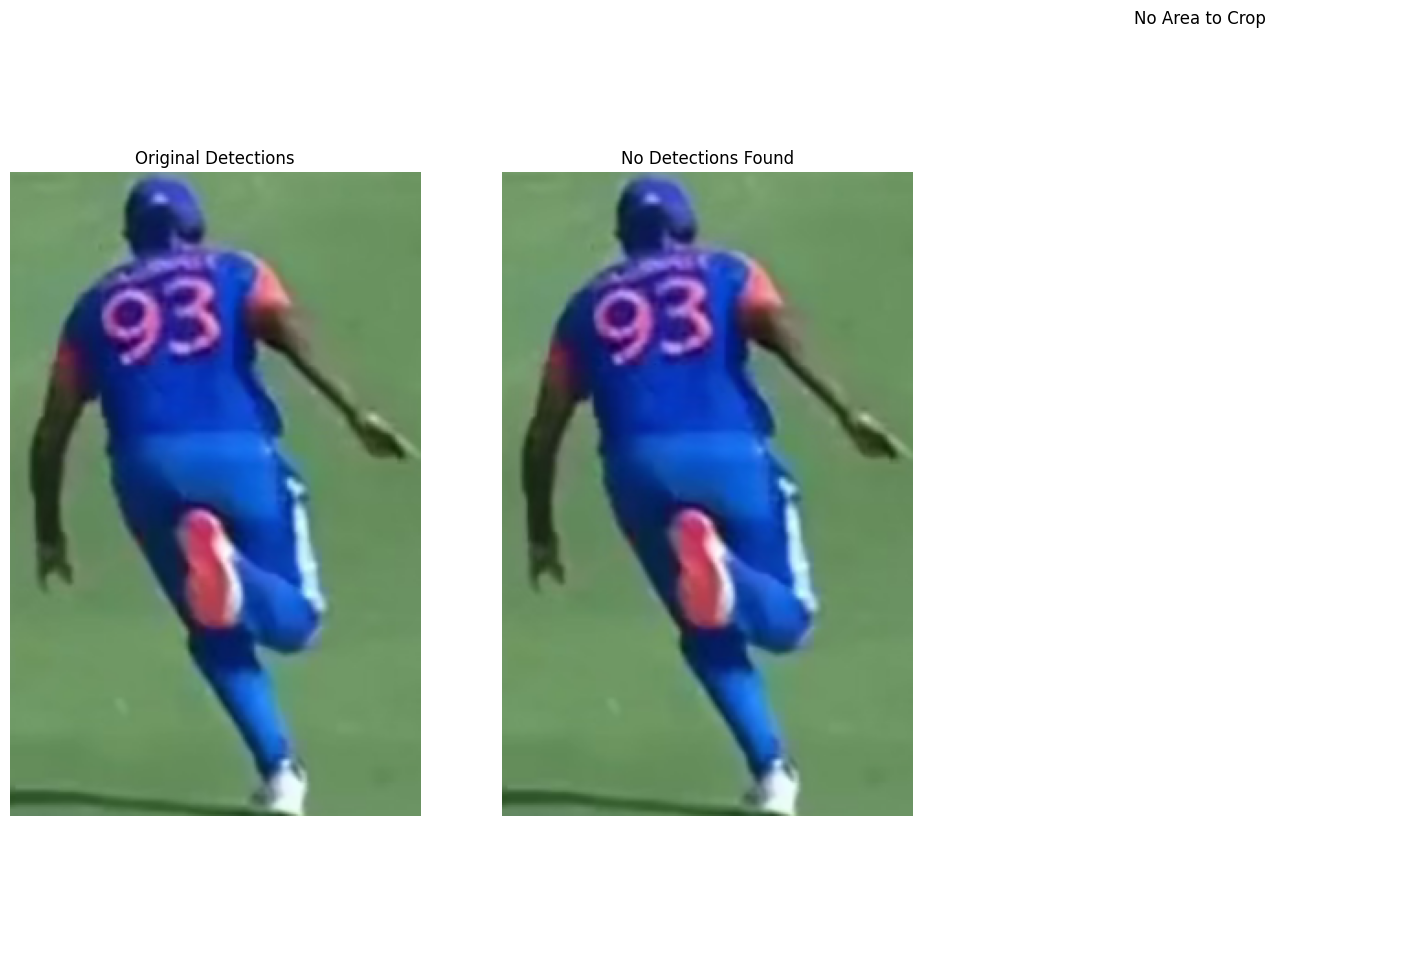

No area was cropped for text recognition.


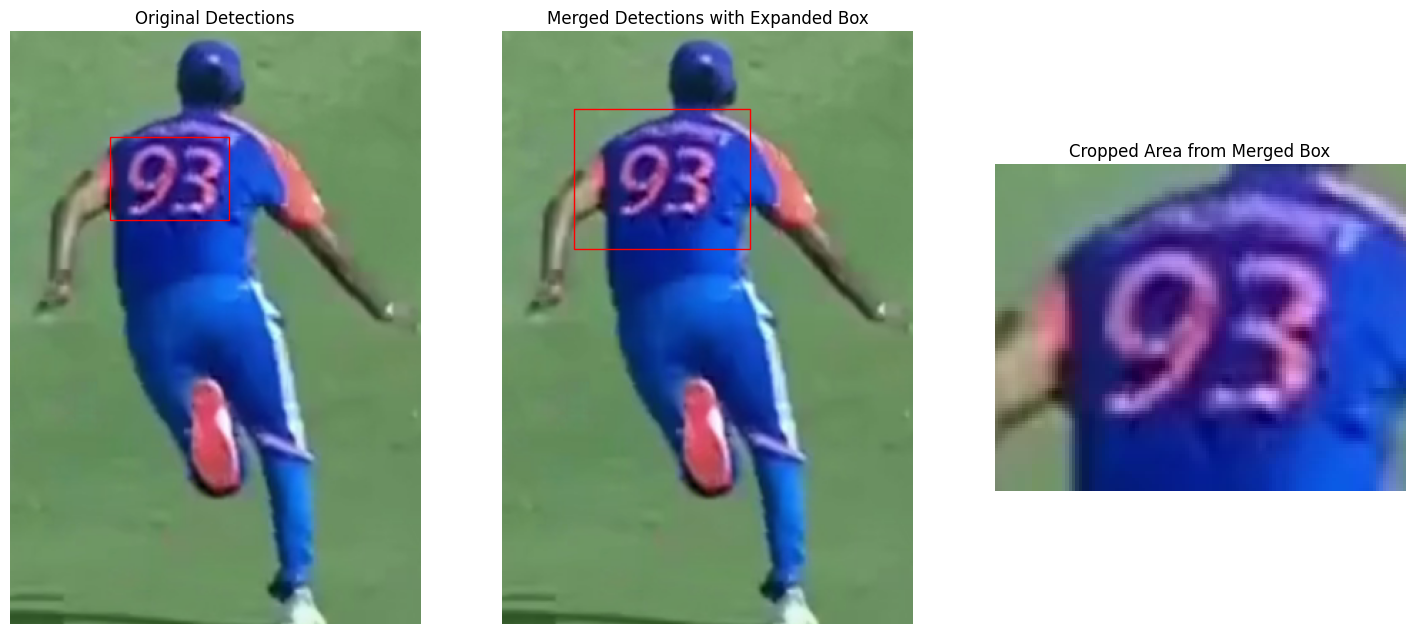

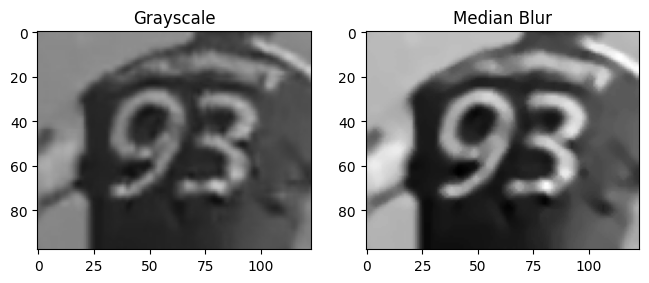

Detected text: 593.



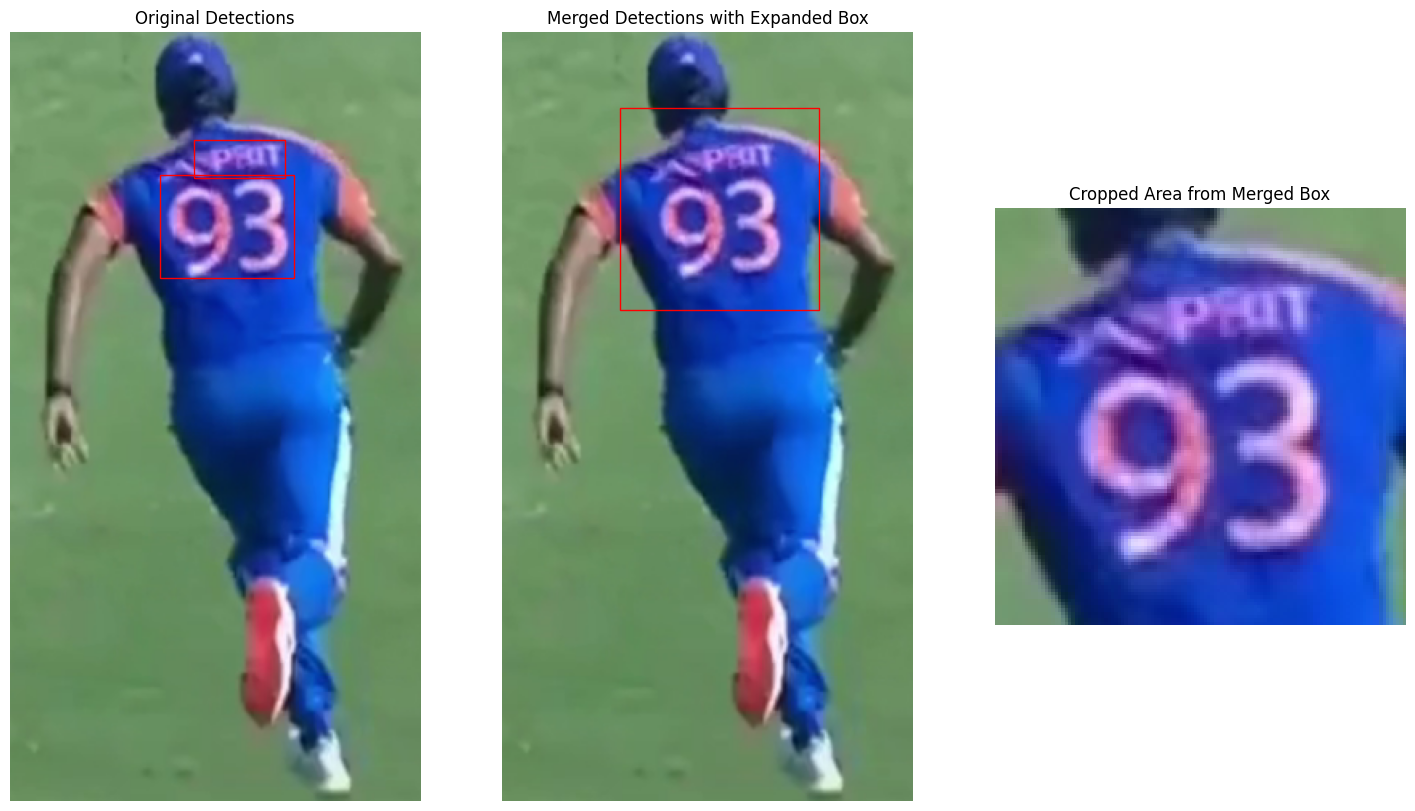

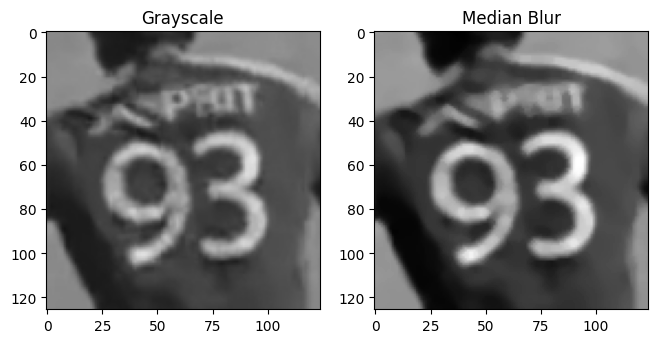

Detected text: Pn

93,



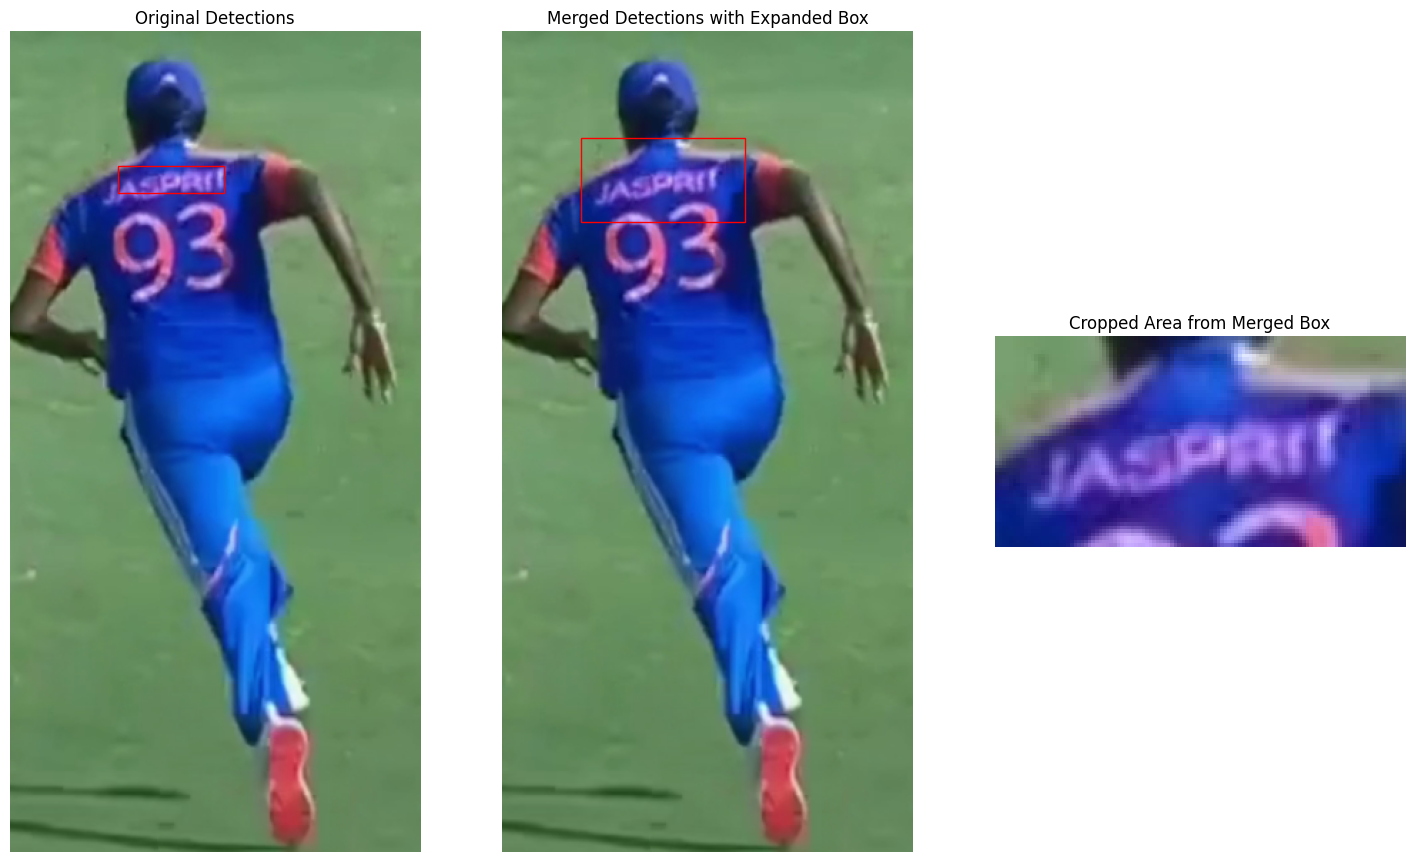

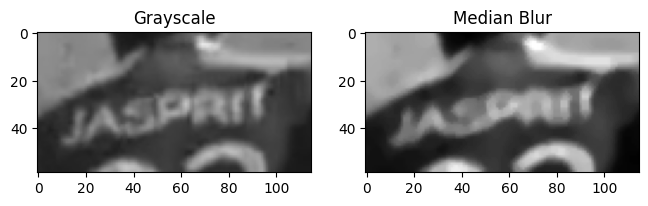

Detected text: eo

—



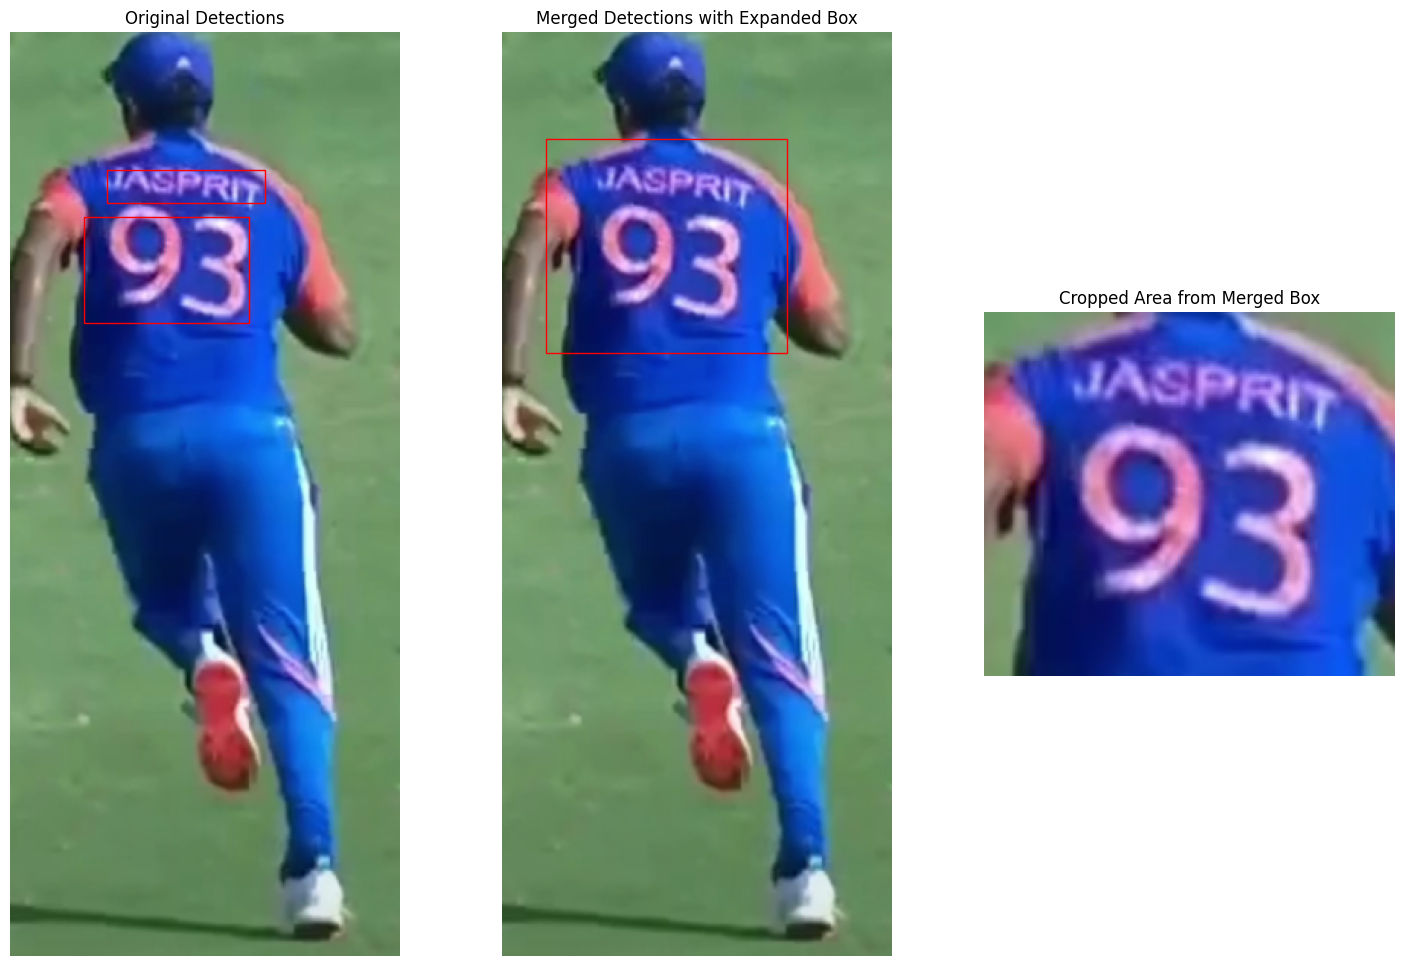

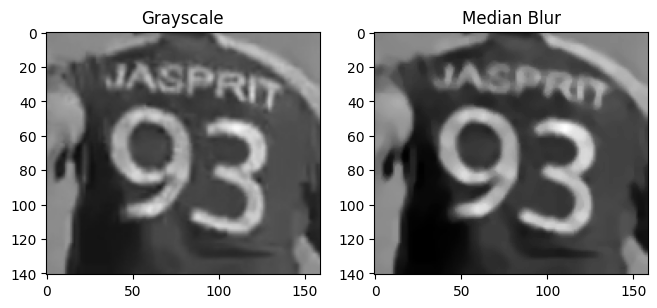

Detected text: 193



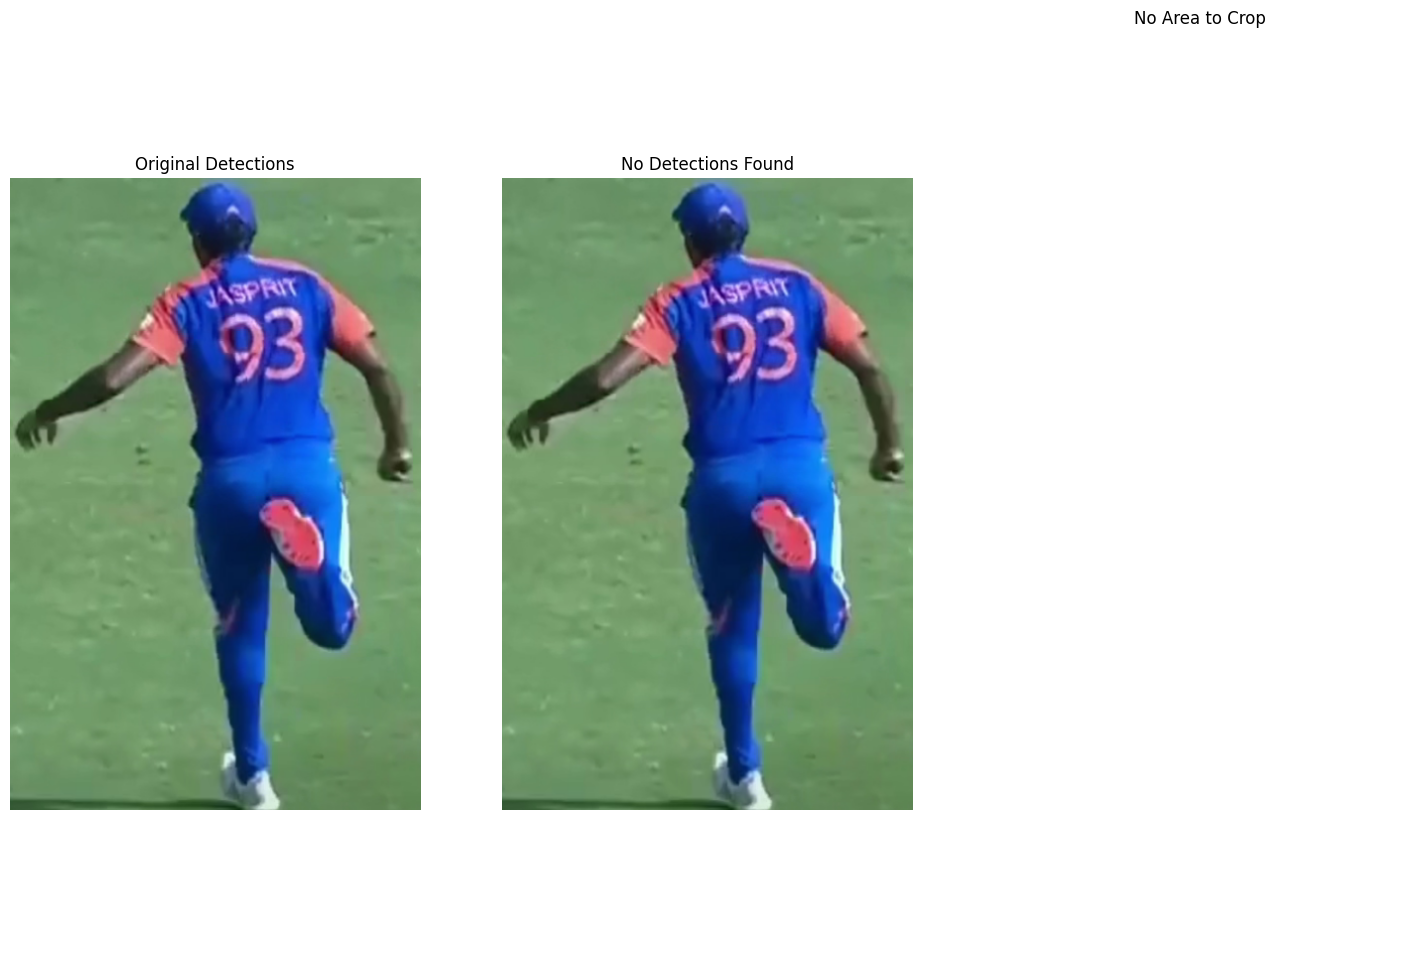

No area was cropped for text recognition.


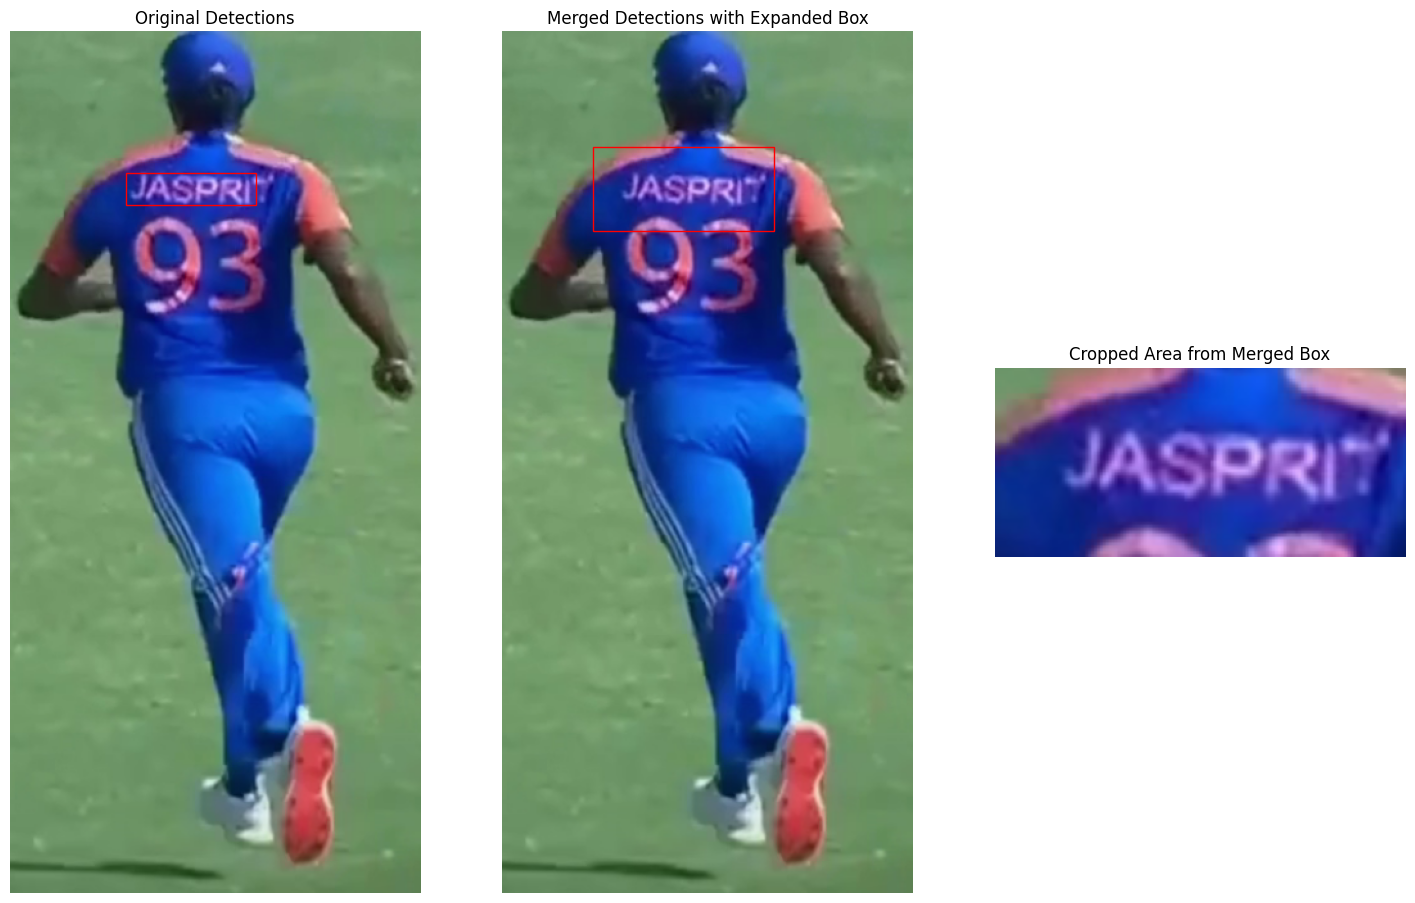

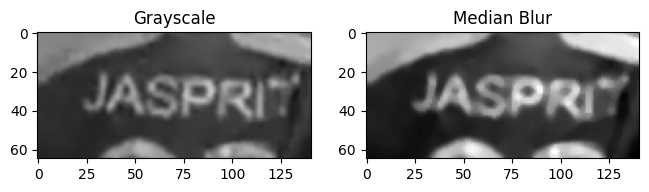

Detected text: JASPRIT

> ~~



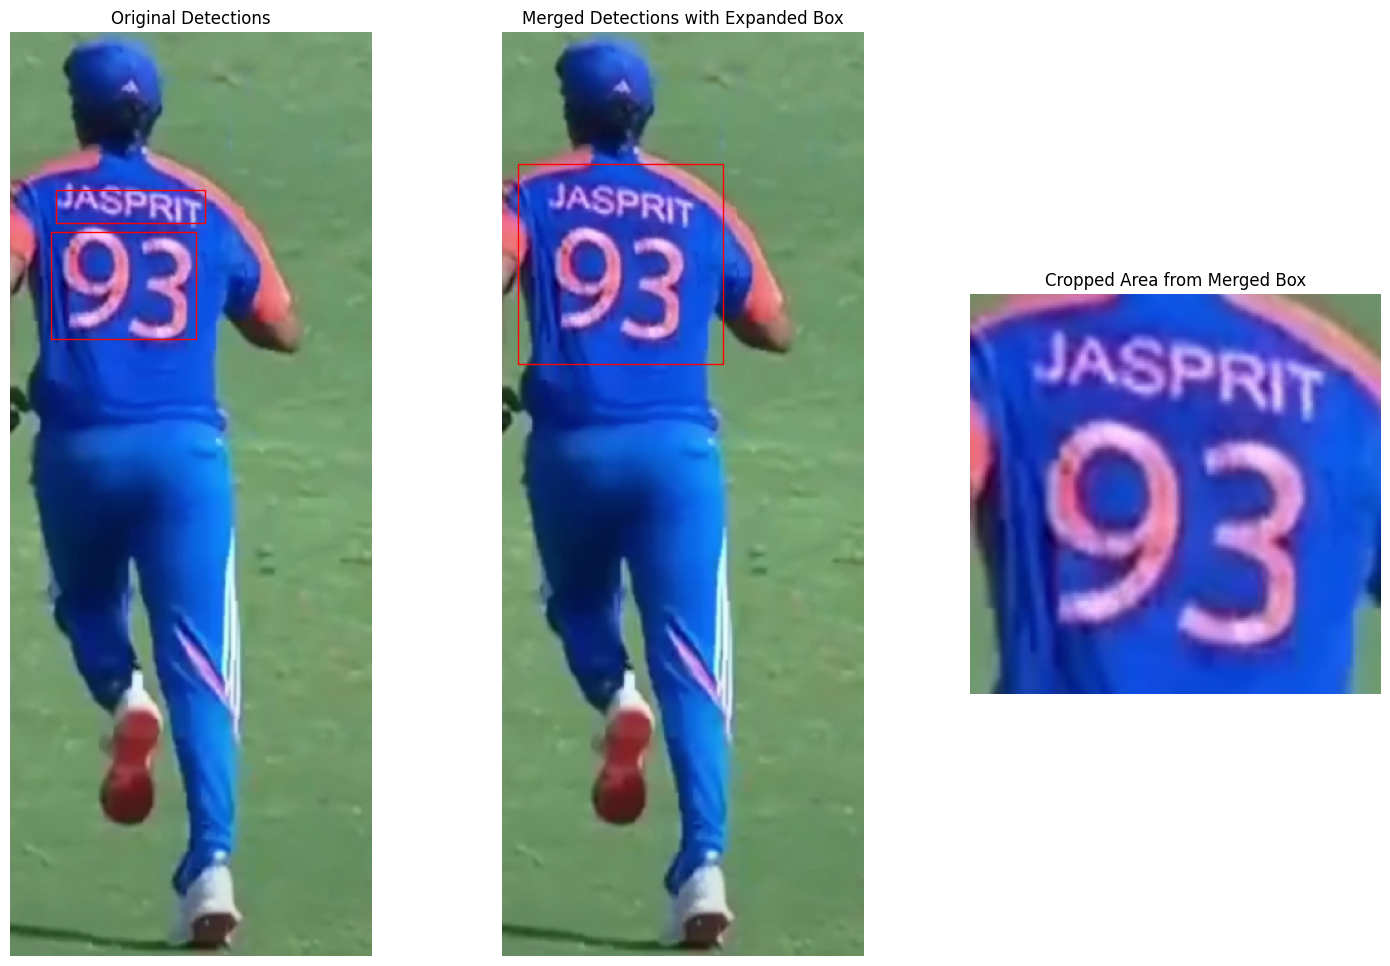

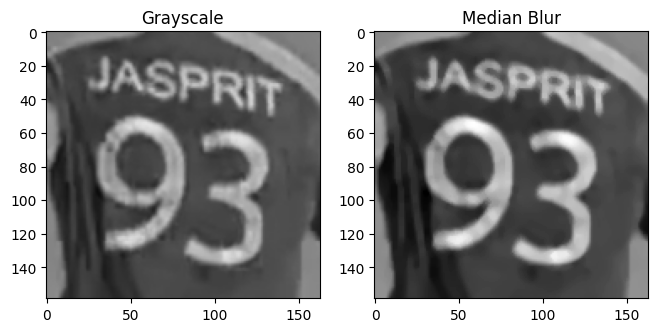

Detected text: ee,

93



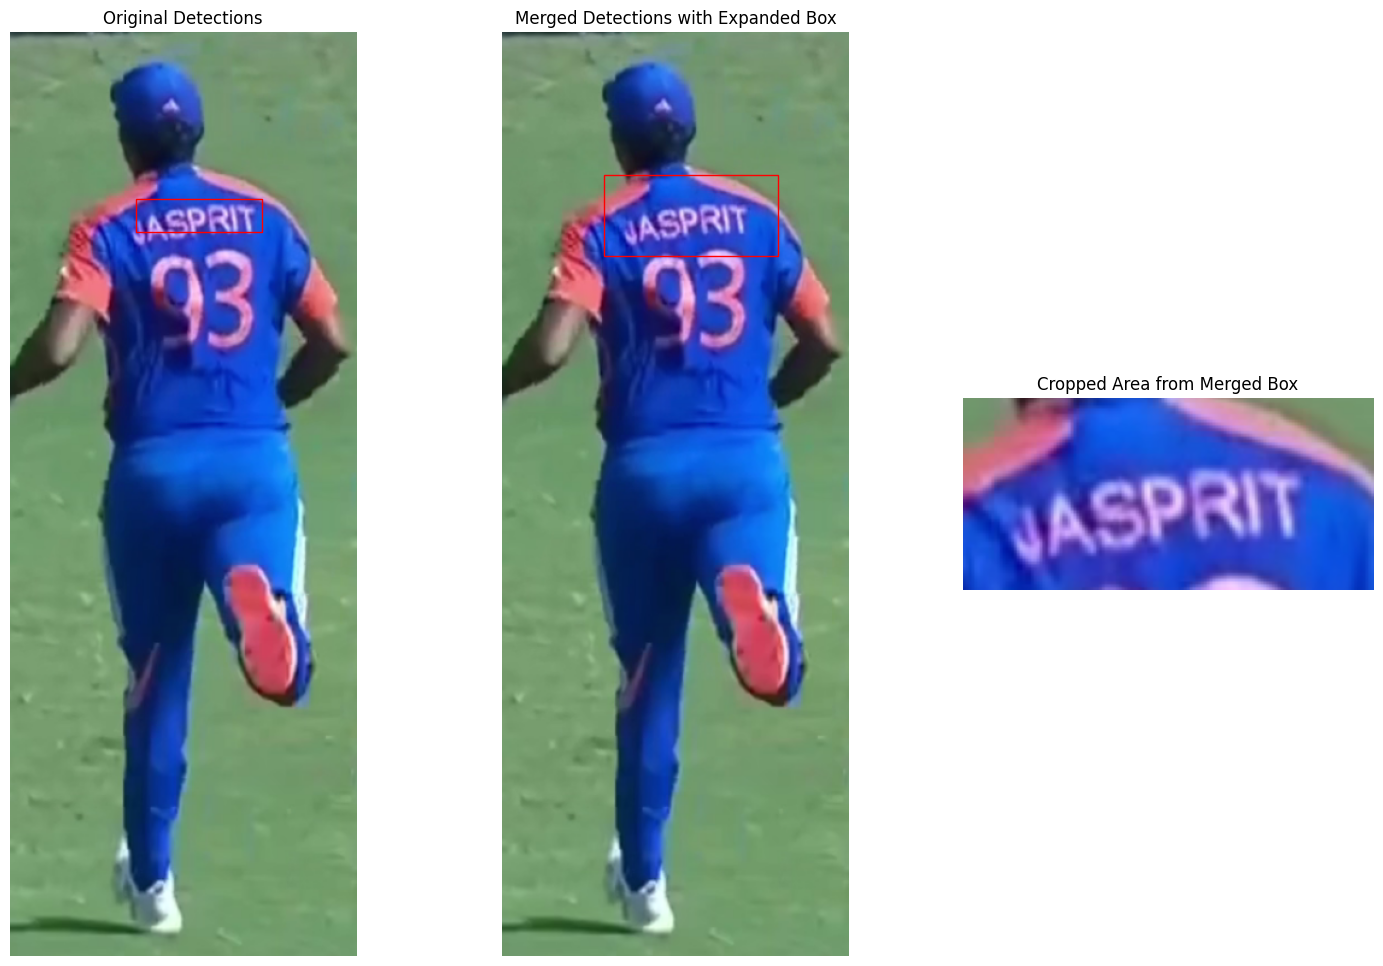

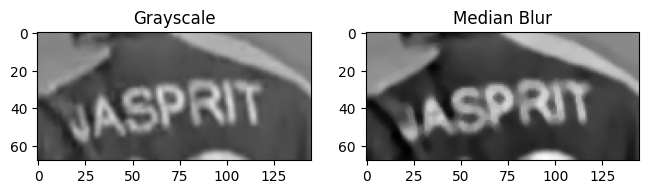

Detected text: VASPRIT



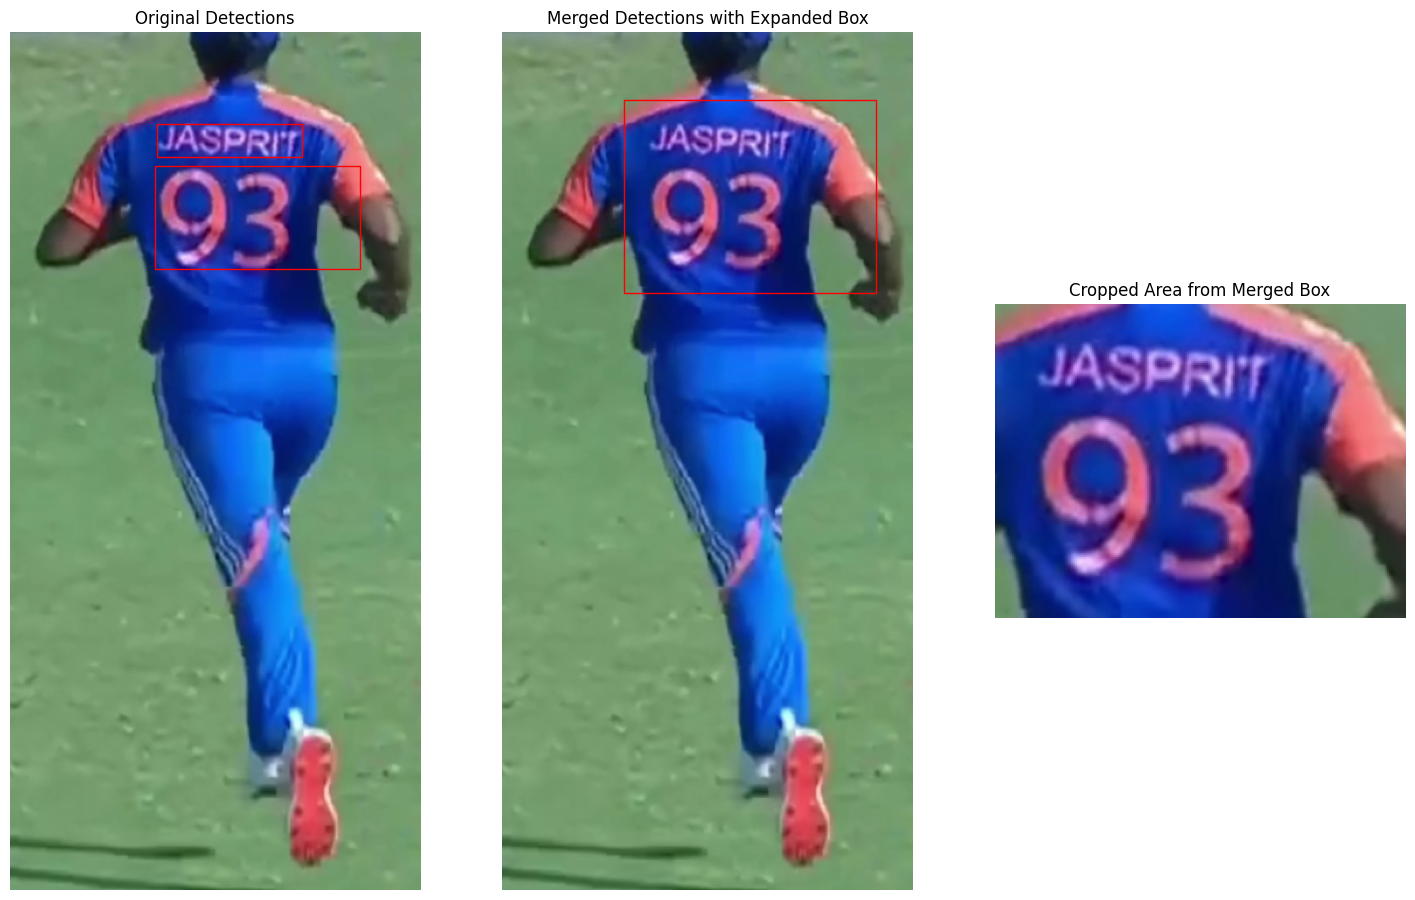

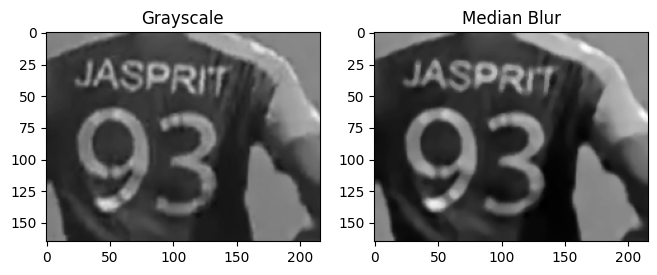

Detected text: Be



In [6]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Create an instance of CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def extract_and_visualize_frames(video_path, output_folder, net, output_layers, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames // num_frames if total_frames > num_frames else 1
    frame_ids = [int(interval * i) for i in range(num_frames)]
    frames = []

    try:
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
    except OSError:
        print(f"Error: Creating directory {output_folder}")

    frame_count = 0
    # fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # Adjust subplot grid and size as needed
    # fig.suptitle('Selected Frames from the Video')
    # ax_flat = axs.flatten()
    
    while frame_count < total_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count in frame_ids:
            # Apply YOLO detection to each frame
            boxes, _ = yolo_detect(net, frame, output_layers)
            if boxes:  # Check if there is at least one detection
                x, y, w, h = boxes[0]  # Use the largest detected box (assuming `yolo_detect` returns such)
                cropped_frame = frame[y:y+h, x:x+w]

                
                resized_frame = cv2.resize(cropped_frame, (224, 224))  # Resize frame as per training

                # Apply CLAHE
                lab = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2LAB)
                l, a, b = cv2.split(lab)
                l = clahe.apply(l)
                processed_img = cv2.merge([l, a, b])
                processed_img = cv2.cvtColor(processed_img, cv2.COLOR_LAB2BGR)

                frames.append(processed_img)

                # # Plotting the frame
                # ax_idx = frame_ids.index(frame_count)
                # ax_flat[ax_idx].imshow(cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))
                # ax_flat[ax_idx].set_title(f"Frame {frame_count}")
                # ax_flat[ax_idx].axis('off')

                process_frame_for_OCR_text_detection(cropped_frame)

            else:
                resized_frame = cv2.resize(frame, (224, 224))  # Resize original frame as fallbac
                print(f"No valid detections at frame {frame_count}.")
        frame_count += 1

    cap.release()
    plt.show()
    return np.array(frames)

# # Load the model and YOLO net
model = load_model('/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/ResNet.h5')
net, output_layers = load_yolo()


# # Properly load the LabelEncoder
encoder = LabelEncoder()
encoder.classes_ = np.load('/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/label_encoder_classes.npy', allow_pickle=True)

# Function to handle frame extraction and visualization by displaying frames
def visualize_frames(video_path):
    frame_folder = 'temp_frames'
    frames = extract_and_visualize_frames(video_path, frame_folder, net, output_layers)
    if frames.size == 0:
        print("No frames to analyze or no valid detections.")

# Example usage
video_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/test_video/3.mov'  # Path to your test video clip
visualize_frames(video_path)


In [9]:
import cv2
import pytesseract
from PIL import Image
import numpy as np

# Load the image
img = cv2.imread('/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/1.png')  # Update this to the path of your downloaded image


# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply thresholding
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# Use median blur to remove noise
blur = cv2.medianBlur(thresh, 5)

# Resize for better accuracy
resized_img = cv2.resize(blur, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# Configure parameters for Tesseract
custom_config = r'--oem 3 --psm 11'
text = pytesseract.image_to_string(resized_img, config=custom_config)

print("Detected text:", text)


Detected text: JASPRIT

193

N

<

-

>

by

o.& |

a

a

7 we

mw ~S

= >

wih.

o-. &



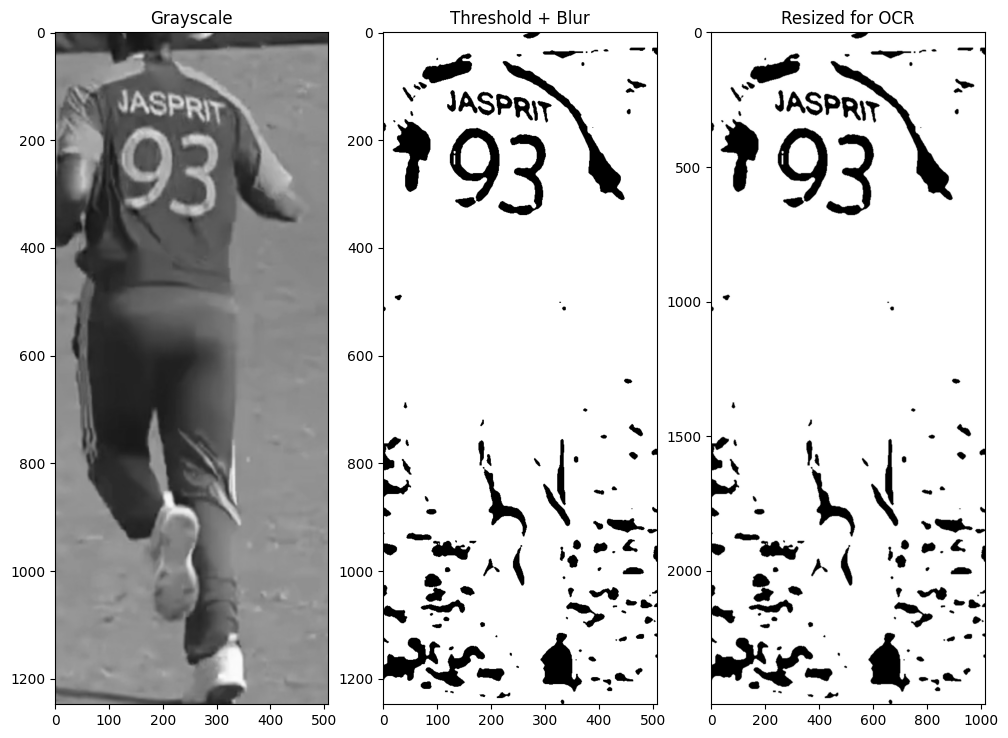

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.title('Grayscale')

plt.subplot(1, 3, 2)
plt.imshow(blur, cmap='gray')
plt.title('Threshold + Blur')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.title('Resized for OCR')

plt.show()


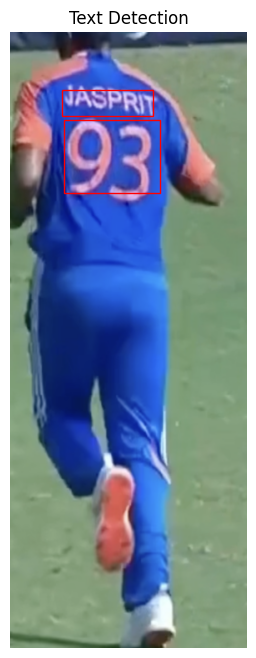

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def main():
    # Load image
    image_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/1.png'
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return

    # Convert image from BGR to RGB for Matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Original dimensions
    (H, W) = image.shape[:2]

    # Set the new width and height to nearest multiple of 32 for EAST model
    newW = int(W / 32) * 32
    newH = int(H / 32) * 32

    # Resize the image to fit model requirements
    image = cv2.resize(image, (newW, newH))

    # Load the pre-trained EAST text detector model
    model_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/frozen_east_text_detection.pb'
    net = cv2.dnn.readNet(model_path)

    # Prepare the image for the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)

    # Layer names for the output layers
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Forward pass of the model to get output
    (scores, geometry) = net.forward(layerNames)

    # Decode the predictions
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # Loop over the number of rows
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # Loop over the number of columns
        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression to avoid overlaps
    indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

    # Draw bounding boxes
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    if len(indices) > 0:
        for i in indices.flatten():
            (startX, startY, endX, endY) = rects[i]
            rect = plt.Rectangle((startX, startY), endX - startX, endY - startY, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    else:
        print("No text regions detected.")

    ax.set_title('Text Detection')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()


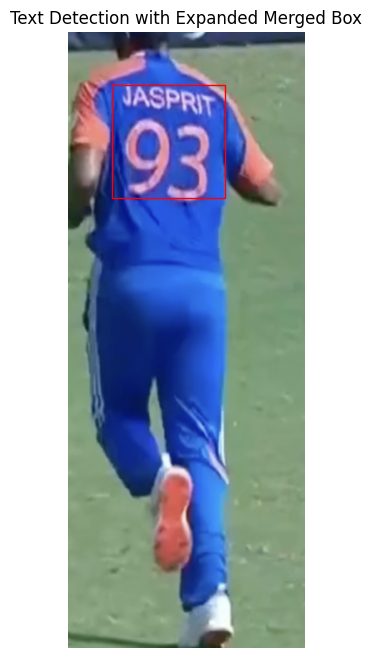

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def main():
    # Load image
    image_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/1.png'  # Update path as needed
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return

    # Convert image from BGR to RGB for Matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Original dimensions
    (H, W) = image.shape[:2]

    # Set the new width and height to nearest multiple of 32 for EAST model
    newW = int(W / 32) * 32
    newH = int(H / 32) * 32

    # Resize the image to fit model requirements
    image = cv2.resize(image, (newW, newH))

    # Load the pre-trained EAST text detector model
    model_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/frozen_east_text_detection.pb'  # Update path as needed
    net = cv2.dnn.readNet(model_path)

    # Prepare the image for the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)

    # Layer names for the output layers
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Forward pass of the model to get output
    (scores, geometry) = net.forward(layerNames)

    # Decode the predictions
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # Loop over the number of rows
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # Loop over the number of columns
        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression to avoid overlaps
    indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

    # Draw bounding boxes
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    if len(indices) > 0:
        # Handle indices correctly depending on their structure
        indices = indices.flatten()  # Ensure indices are a flat array

        # Calculate the min and max coordinates to merge bounding boxes
        margin_horizontal = 15  # Horizontal margin
        margin_vertical = 10   # Vertical margin - increased compared to horizontal
        min_x = max(0, min([rects[i][0] for i in indices]) - margin_horizontal)
        min_y = max(0, min([rects[i][1] for i in indices]) - margin_vertical)
        max_x = min(W, max([rects[i][2] for i in indices]) + margin_horizontal)
        max_y = min(H, max([rects[i][3] for i in indices]) + margin_vertical)

        # Draw the expanded bounding box
        rect = plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    else:
        print("No text regions detected.")

    ax.set_title('Text Detection with Expanded Merged Box')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()


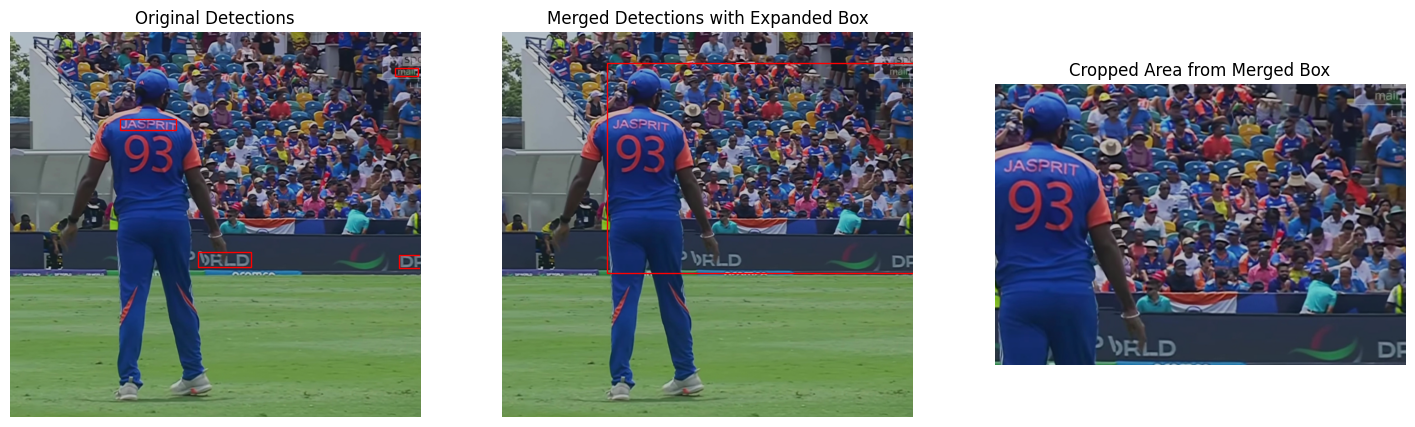

NameError: name 'pytesseract' is not defined

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def main():
    # Load image
    image_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/resnet_data/Jasprit_Bumrah/Screen Recording 2024-07-22 at 12.19.08 PM_frame_19.jpg'
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return

    # Convert image from BGR to RGB for Matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Original dimensions
    (H, W) = image.shape[:2]

    # Set the new width and height to nearest multiple of 32 for EAST model
    newW = int(W / 32) * 32
    newH = int(H / 32) * 32

    # Resize the image to fit model requirements
    image = cv2.resize(image, (newW, newH))

    # Load the pre-trained EAST text detector model
    model_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/frozen_east_text_detection.pb'
    net = cv2.dnn.readNet(model_path)

    # Prepare the image for the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)

    # Layer names for the output layers
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Forward pass of the model to get output
    (scores, geometry) = net.forward(layerNames)

    # Decode the predictions
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # Loop over the number of rows
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # Loop over the number of columns
        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression to avoid overlaps
    indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

    # Plot the figures side by side
    plt.figure(figsize=(18, 12))

    # Plot original detections
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    for i in indices.flatten():
        (startX, startY, endX, endY) = rects[i]
        rect = plt.Rectangle((startX, startY), endX - startX, endY - startY, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
    plt.title('Original Detections')
    plt.axis('off')

    # Plot merged box
    plt.subplot(1, 3, 2)
    plt.imshow(image)

    cropped_img = None

    if len(indices) > 0:
        min_x = max(0, min([rects[i][0] for i in indices]) - 20)
        min_y = max(0, min([rects[i][1] for i in indices]) - 20)
        max_x = min(W, max([rects[i][2] for i in indices]) + 20)
        max_y = min(H, max([rects[i][3] for i in indices]) + 20)

        cropped_img = image[min_y:max_y, min_x:max_x]

        merged_rect = plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, edgecolor='r', facecolor='none')
        plt.gca().add_patch(merged_rect)
        plt.title('Merged Detections with Expanded Box')
    else:
        plt.title('No Detections Found')
    plt.axis('off')

    # Display the cropped area from the merged box
    plt.subplot(1, 3, 3)
    if len(indices) > 0:
        plt.imshow(cropped_img)
        plt.title('Cropped Area from Merged Box')
    else:
        plt.title('No Area to Crop')
    plt.axis('off')

    plt.show()


    # Proceed with text recognition on the cropped image
    if cropped_img is not None:
        # Convert cropped image from RGB to BGR for OpenCV operations
        cropped_img_bgr = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR)
        
        # Convert to grayscale
        gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)

        # # Apply thresholding
        # _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

        # Use median blur to remove noise
        blur = cv2.medianBlur(gray, 5)

        # # Resize for better accuracy
        # resized_img = cv2.resize(blur, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

        # Configure parameters for Tesseract
        custom_config = r'--oem 3 --psm 11'
        text = pytesseract.image_to_string(blur, config=custom_config)

        # plotting the preprocessing visualization of the cropped image
        plt.figure(figsize=(12, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
        plt.title('Grayscale')

        plt.subplot(1, 3, 2)
        plt.imshow(blur, cmap='gray')
        plt.title('Median Blur')

        # plt.subplot(1, 3, 3)
        # plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
        # plt.title('Resized for OCR')

        plt.show()

        print("Detected text:", text)
    else:
        print("No area was cropped for text recognition.")


if __name__ == "__main__":
    main()
